# Synthetic Cells Dataset

The image dataset is [BBBC024](https://data.broadinstitute.org/bbbc/BBBC024/) available from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/index.html) ([Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083)).

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path

import numpy as np
import tensorflow as tf
#tf.enable_eager_execution()

import tqdm
from skimage import io
from sklearn.model_selection import train_test_split

import sys
sys.path.append("../../../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Synthetic_Cells")

data_dir = root_dir / "Data"
data_dir.mkdir(parents=True, exist_ok=True)

raw_data_dir = data_dir / "raw"
raw_data_dir.mkdir(parents=True, exist_ok=True)

params = maskflow.load_parameters("parameters.yml")
class_names = params["CLASS_NAMES"]

# Copy config next to data folder
maskflow.save_parameters(params, root_dir / "parameters.yml")

tfrecord_train_writer_path = data_dir / "training_data.tfrecord"
tfrecord_evaluation_writer_path = data_dir / "evaluation_data.tfrecord"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Build the dataset

In [46]:
if len(list(raw_data_dir.glob("*"))) == 0:
    dataset_url = "https://data.broadinstitute.org/bbbc/BBBC038/stage1_train.zip"
    maskflow.utils.download_zip(dataset_url, raw_data_dir)
        
tfrecord_train_writer = tf.python_io.TFRecordWriter(str(tfrecord_train_writer_path))
tfrecord_evaluation_writer = tf.python_io.TFRecordWriter(str(tfrecord_evaluation_writer_path))
       
dirnames = list(raw_data_dir.iterdir())[:10]
    
training_size = 0.8
train_ids, _ = train_test_split(np.arange(0, len(dirnames)), train_size=training_size)
    
for i, dirpath in enumerate(tqdm.tqdm(dirnames, total=len(dirnames))):
    # Open the image and remove the alpha channel
    im_path = dirpath / "images" / (dirpath.stem + ".png")
    im = io.imread(im_path)[:, :, :3]
    
    masks = []
    for mask_path in (dirpath / "masks").glob("*.png"):
        mask = io.imread(mask_path)
        masks.append(mask)
    masks = np.array(masks)
    
    class_ids = np.ones([masks.shape[0]], dtype=np.int32)
    
    tf_example = maskflow.create_tf_example(i, dirpath.stem, im, masks, class_ids)
    
    # Save it in the training or the eval dataset?
    if i in train_ids:
        tfrecord_train_writer.write(tf_example.SerializeToString())
    else:
        tfrecord_evaluation_writer.write(tf_example.SerializeToString())

tfrecord_train_writer.close()
tfrecord_evaluation_writer.close()

/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


## Visualize some images with annotations

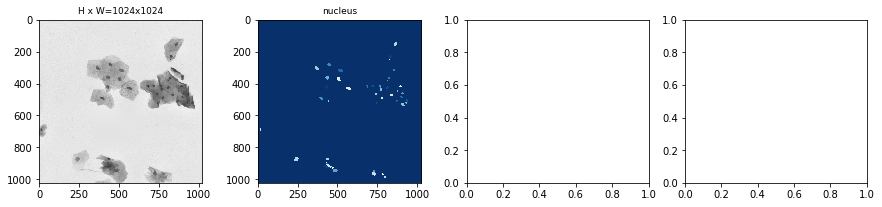

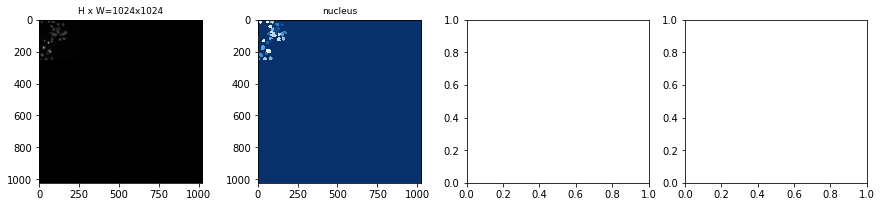

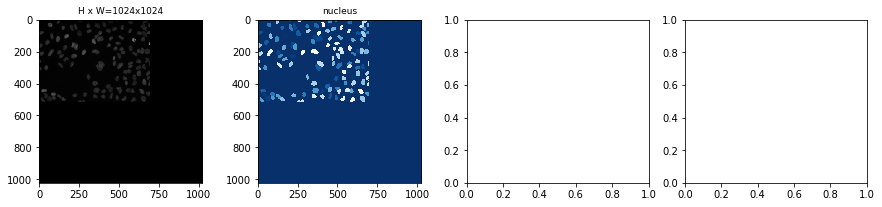

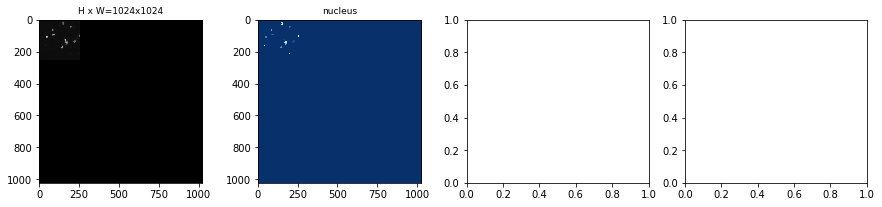

In [47]:
# Retrieve some data
images, annotations = maskflow.get_data(tfrecord_train_writer_path, n=4, shuffle=True)

# Display them
maskflow.batch_display_top_masks(images, annotations["masks"], annotations["class_ids"],
                                 params["CLASS_NAMES"], limit=3, basesize=15)